# Analisi multiprocessing

Di seguito alcune considerazioni sull'utilizzo
del multiprocessing per la parallelizzazione di
un algoritmo genetico.


## Motivazioni

L'utilizzo del modulo `multiprocessing` è ciò che
viene considerato lo standard per il calcolo
parallelo in Python, soprattutto se si parla di
task CPU bound.

Permette di aggirare il problema introdotto dal
GIL, il quale non permette il classico paradigma
multithread, possibile in altri linguaggi come C o
C++.

Tramite multiprocessing è dunque possibile non
scendere a compromessi in quanto ad espressività
del codice. Il programmatore è libero di scrivere
il suo algoritmo genetico utilizzato tipi e
strutture dati native di Python e, se necessario
può ricorrere a librerie di terze parti senza
problemi.


### Problematiche

Il multiprocessing di contro non è la cosa più
leggera che ci sia. Di certo non è possibile
pensare ad un approccio in cui i processi vengono
creati e distrutti ad ogni iterazione, in quanto
si genererebbe del dell'overhead sicuramente non
trascurabile.

La scelta di creare un pool di processi worker che
rimane in vita dall'inizio alla fine
dell'esecuzione è dunque una scelta quasi obbligata
e che introduce la necessità di un qualche
meccanismo di sincronizzazione per avviare e
mettere in attesa i processi.

L'altro potenziale limite è l'assenza di memoria
condivisa. Non è dunque possibile avere strutture
dati condivise tramite puntatori o definite
globalmente a cui ogni processi può accedere. Anche
qui la scelta di condividere parti della struttura
dati tramite qualche meccanismo di streaming dati
è praticamente obbligata.


#### Memoria condivisa

Esiste la possibilità di creare un blocco di
memoria condivisa che risiede al di fuori di ogni
worker e al quale è possibile accedere in modo
diretto come si farebbe tramite multithreading.

Ho trovato tuttavia questo meccanismo molto
limitante per l'espressività che vorrebbe in
qualche modo garantire la libreria. Il motivo è
che per riuscire a accedere direttamente al blocco
di memoria lo si deve fare tramite oggetti che
supportano il **Buffer Protocol** di Python, come
ad esempio _numpy array_ o _bytearray_.

Questo limita molto i tipi e le strutture dati
che si vogliono impiegare e ci spinge ad un
approccio più classico in cui possiamo manipolare
solo array numerici o simili.

Non sarebbe quindi possibile avere cromosomi
dalla struttura complessa ma soprattutto
personalizzata.


## Modello di calcolo parallelo

Il modello di calcolo proposto si offre di operare
in parallelo nelle fasi di crossover, mutazione e
valutazione.

Una volta selezionati gli individui per la
riproduzione, si suddivide la lista che li contiene
in $W$ chunk uguali, dove $W$ è il numero di
processi worker. Ciascun chunk viene poi inviato
ai worker.

Per la condivisione ho optato per un meccanismo
basato su code (`multiprocessing.Queue`) di
comunicazione. Ogni processo possiede due code, una
per la ricezione dati, l'altra per l'invio.

![queue](images/queue.svg)

Le code permettono di implementare in modo molto
semplice il paradigma _produttore-consumatore_,
fornendo due metodi principali (`put` e `get`)
che permettono rispettivamente di

- Inserire un elemento nella coda. Se questa è
  piena il processo si blocca finché non vi è
  uno slot libero.
- Estrarre un elemento dalla coda. Nel caso in cui
  questa sia vuota ci si blocca in attesa che un
  elemento venga inserito.

Per velocizzare ulteriormente l'invio e la
ricezione dati ho fatto uso della libreria
`asyncio`, la quale, tramite la sintassi
`async`/`await` permette di effettuare operazioni
I/O bound in modo asincrono.


### Pipeline di ricezione

Una prima implementazione consisteva semplicemente
nell'inviare per intero il chunk di struttura dati
al worker. Questo però potrebbe costituire un
ostacolo alle performance nel momento in cui la
fase di calcolo parallelo non è particolarmente
pesante o quando la popolazione presa in esame
risulta particolarmente grande.

Per mitigare il problema è possibile suddividere
ognuno dei chunk da inviare ai worker in ulteriori
_sub-chunk_. In questo modo, il worker potrebbe
ricevere i _sub-chunk_ asincronamente mentre
elabora quelli già ricevuti.

![pipeline](images/recv_pipeline.svg)

Come mostrato in figura, l'estrazione dei chunk di
struttura dati viene delegata ad un thread del
worker. Una volta che il thread estrae un elemento
dalla coda lo mette a sua volta in una coda in
memoria condivisa con il processo worker vero e
proprio. A questo punto il worker può estrarre il
chunk ed iniziare ad elaborarlo mentre il thread
continua ad estrarre il resto dei dati. La coda in
memoria condivisa non impiega la serializzazione
(e deserializzazione) per inserire ed estrarre dati
risultando quindi a basso overhead.

## Prestazioni della coda

Per valutare la bontà del modello ho preso in considerazione il tempo
necessario ad

- inserire un singolo individuo in coda.
- effettuare le operazioni di crossover, mutazione e valutazione per un singolo
  individuo.
- effettuare le due operazioni precedenti ma per un gruppo di individui.


In [1]:
import sys

# chromosome length
chromosome = [i for i in range(500)]
print(f"chromosome size: {sys.getsizeof(chromosome) / 1024.0:.2f} KB")

chromosome size: 4.12 KB


Passiamo ora a costruire 3 diverse popolazioni, rispettivamente da $10.000$,
$20.000$ e $50.0000$ individui.


In [2]:
import pandas as pd

population_sizes = [10000, 20000, 50000]
populations = [[chromosome for _ in range(size)] for size in population_sizes]

populations_df = {
    "individuals": [size for size in population_sizes],
    "size (KB)": [sys.getsizeof(pop) / 1024.0 for pop in populations],
}

populations_df = pd.DataFrame(populations_df)
populations_df

,individuals,size (KB)
0,10000,83.179688
1,20000,168.960938
2,50000,433.960938


Per ognuna delle popolazioni andiamo a valutare il tempo medio di inserimento
ed estrazione di un individuo nella coda.


In [3]:
import multiprocessing as mp
import time

import pandas as pd

dfs = []

buffer = mp.Queue()
single_timings = {"size": [], "put time (ms)": [], "get time (ms)": []}
for p, size in zip(populations, population_sizes):
    for _ in range(size):
        start = time.perf_counter()
        buffer.put(chromosome)
        put_end = time.perf_counter()
        buffer.get()
        get_end = time.perf_counter()

        single_timings["size"].append(size)
        single_timings["put time (ms)"].append((put_end - start) * 1000.0)
        single_timings["get time (ms)"].append((get_end - put_end) * 1000.0)

single_timings = pd.DataFrame(single_timings)
single_timings.groupby("size").mean()

,put time (ms),get time (ms)
size,,
10000,0.009398,0.033215
20000,0.009536,0.033939
50000,0.009432,0.033080


Vediamo invece il tempo totale di inserimento ed estrazione di tutti gli
individui uno per uno.


In [4]:
single_timings.groupby("size").sum()

,put time (ms),get time (ms)
size,,
10000,93.975438,332.152777
20000,190.727999,678.775797
50000,471.581824,1653.992016


Andiamo ora a valutare il tempo necessario ad inserire ed estrarre l'intera
popolazione in un colpo solo.


In [5]:
assert buffer.empty()

whole_pop_timings = {"size": [], "put time (ms)": [], "get time (ms)": []}
for pop, size in zip(populations, population_sizes):
    start = time.perf_counter()
    buffer.put(pop)
    put_end = time.perf_counter()
    buffer.get()
    get_end = time.perf_counter()

    whole_pop_timings["size"].append(size)
    whole_pop_timings["put time (ms)"].append((put_end - start) * 1000.0)
    whole_pop_timings["get time (ms)"].append((get_end - put_end) * 1000.0)

whole_pop_timings = pd.DataFrame(whole_pop_timings)
whole_pop_timings

,size,put time (ms),get time (ms)
0,10000,0.020894,0.421567
1,20000,0.013826,0.370325
2,50000,0.013852,0.845285


Andiamo a comparare i tempi medi di inserimento ed estrazione di un singolo
individuo con i tempi necessari ad inserire ed estrarre l'intera popolazione.


In [6]:
whole_pop_timings.groupby("size").sum() / single_timings.groupby("size").mean()

,put time (ms),get time (ms)
size,,
10000,2.223347,12.691961
20000,1.449813,10.911556
50000,1.468674,25.552874


Prendiamo ad esempio la popolazione da $50.000$ individui, con un peso totale
di circa $433$ KB. Si nota subito che occupa almeno 100 volte la memoria
occupata da un singolo cromosoma. Ad ogni modo, il tempo di estrazione
dell'intera popolazione non è 100 volte superiore ma circa 23 volte superiore.

Compariamo ora il tempo necessario ad inserire ed estrarre l'intera popolazione
un individuo alla volta, con il tempo necessario ad inserirla ed estrarla in un
colpo solo.


In [7]:
single_timings.groupby("size").sum() / whole_pop_timings.groupby("size").sum()

,put time (ms),get time (ms)
size,,
10000,4497.723642,787.900326
20000,13794.879828,1832.919183
50000,34044.313177,1956.727041


Risulta chiaro il vantaggio che si inserendo più dati alla volta ma meno volte
rispetto ad inserire pochi byte per volta ma molte volte.

Per quanto riguarda invece il singolo inserimento o estrazione dalla coda,
lavorare con meno byte risulta più vantaggioso ma il miglioramento è di gran
lunga più marcato nel caso in cui si lavori con l'intera popolazione in blocco.


#### Suddivisione della popolazione in chunk

Al fine di migliorare il modello che ho implementato, è interessante vedere
la differenza in prestazioni quando si suddivide la popolazione in chunk.

Per ognuna delle popolazioni ho valutato chunk di dimensioni pari alla
popolazione stessa e poi via via più piccoli dividendo per 2.


In [8]:
import math

chunk_df = {"size": [], "chunksize": [], "put time (ms)": [], "get time (ms)": []}

for size, pop in zip(population_sizes, populations):
    chunksize = size
    for _ in range(6):
        for i in range(0, len(pop), chunksize):
            start = time.perf_counter()
            buffer.put(pop[i : i + chunksize])
            put_end = time.perf_counter()
            buffer.get()
            get_end = time.perf_counter()

            chunk_df["size"].append(size)
            chunk_df["chunksize"].append(chunksize)
            chunk_df["put time (ms)"].append((put_end - start) * 1000.0)
            chunk_df["get time (ms)"].append((get_end - put_end) * 1000.0)

        chunksize = math.ceil(chunksize / 2)

chunk_df = pd.DataFrame(chunk_df)
chunk_df

,size,chunksize,put time (ms),get time (ms)
0,10000,10000,0.062319,0.744272
1,10000,5000,0.025784,0.785533
2,10000,5000,0.027459,0.510120
3,10000,2500,0.063713,0.409669
4,10000,2500,0.023185,0.159259
...,...,...,...,...
184,50000,1563,0.017265,0.073723
185,50000,1563,0.018215,0.076989
186,50000,1563,0.016614,0.077350
187,50000,1563,0.017414,0.072894


In [9]:
import matplotlib.pyplot as plt


def plot_chunk(size: int):
    df = chunk_df[chunk_df["size"] == size].sort_values(by="chunksize")
    chunksizes = df["chunksize"].unique()

    mean_put = df.groupby("chunksize").mean()["put time (ms)"]
    mean_get = df.groupby("chunksize").mean()["get time (ms)"]

    tot_put = df.groupby("chunksize").sum()["put time (ms)"]
    tot_get = df.groupby("chunksize").sum()["get time (ms)"]

    plt.figure(figsize=(12, 6))
    plt.title(f"Population size: {size}")
    plt.xticks(chunksizes)
    plt.xlabel("Chunksize")
    plt.ylabel("Operation time")
    # plt.xscale("log")

    plt.plot(chunksizes, mean_put, label=f"mean put time", marker="s")
    plt.plot(chunksizes, mean_get, label=f"mean get time", marker="s")

    plt.plot(chunksizes, tot_put, label=f"total put time", marker="o")
    plt.plot(chunksizes, tot_get, label=f"total get time", marker="o")

    plt.legend()
    plt.grid()
    plt.show()

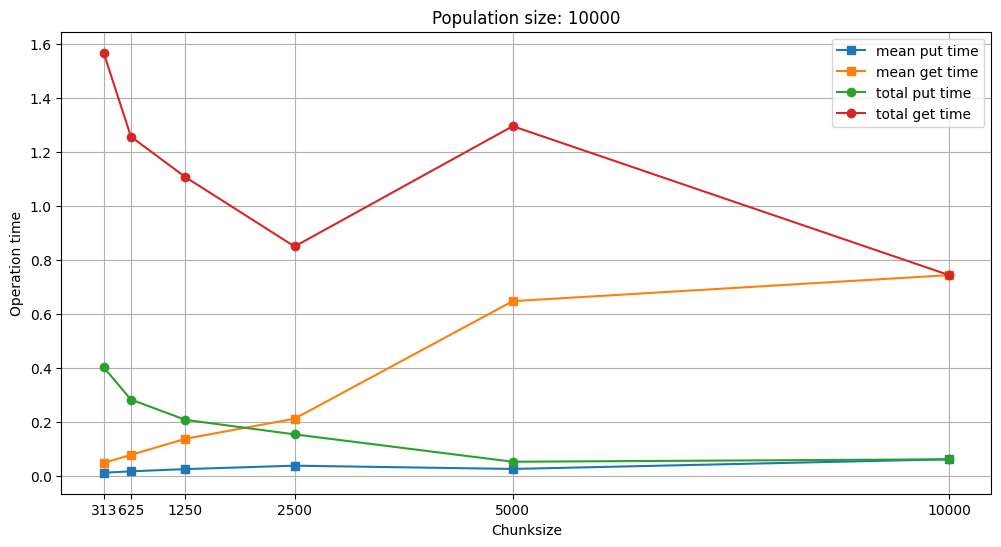

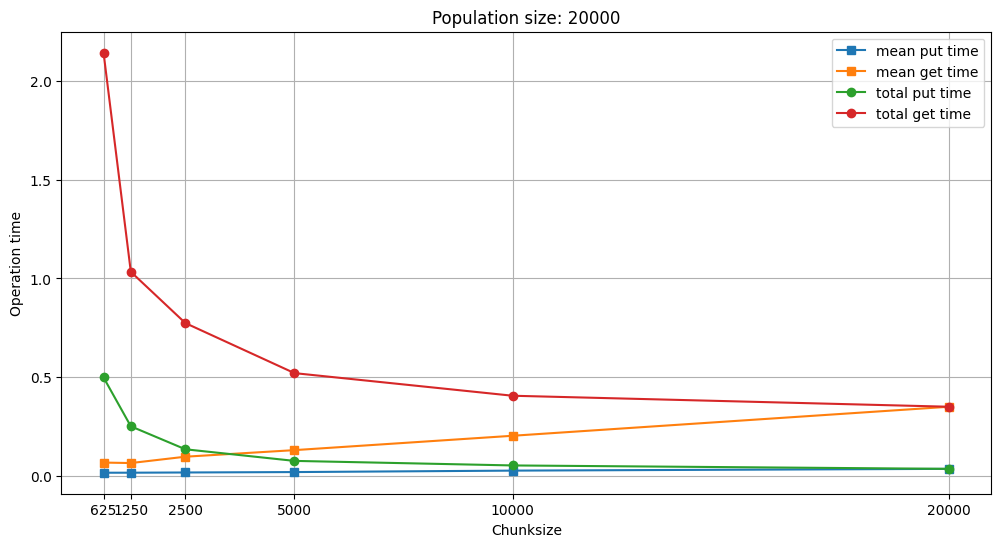

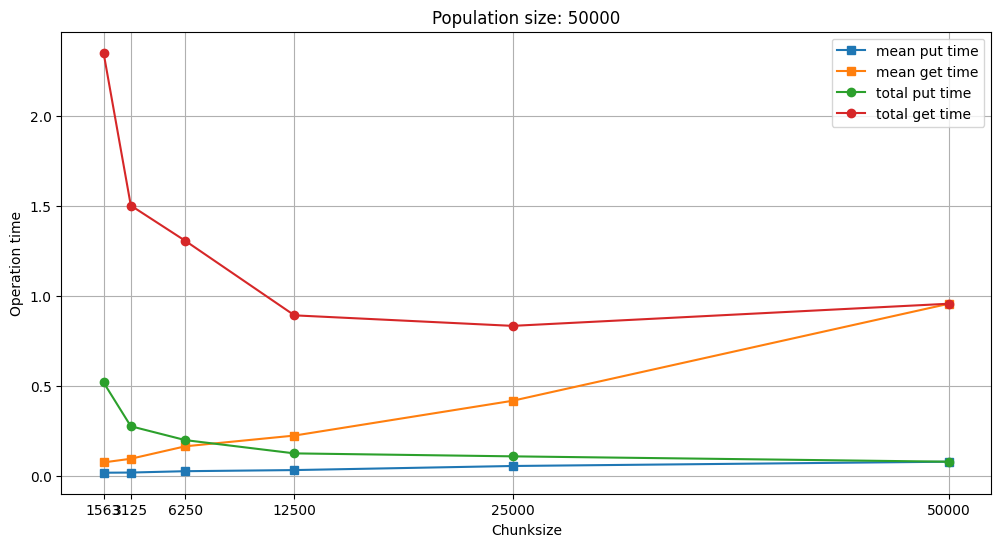

In [10]:
plot_chunk(10000)
plot_chunk(20000)
plot_chunk(50000)

Come possiamo vedere dai grafici, i tempi di inserimento rimangono bassi. Sono
i tempi estrazione che si comportano in modo interessante.

Quando si hanno tanti chunk piccoli, il tempo medio di estrazione è basso ma
il tempo totale per estrarre tutta la popolazione tende ad essere più grande.

Quando invece si hanno pochi chunk grandi vediamo che il tempo totale di
estrazione dell'intera popolazione tende a diminuire. Notiamo anche che
mantenere un numero di chunk basso ma comunque diverso da 1 ha prestazioni
molto simili a lavorare con l'intera popolazione in blocco.


## Prestazioni calcolo parallelo

Passiamo alle prestazioni offerte dal modello di calcolo parallelo. Al momento
il problema che sto trattando lavora su una funzione di valutazione della
fitness troppo leggera per apprezzare uno _speed-up_ significativo. Ho aggiunto
quindi un ritardo artificiale tramite un `sleep` di un millisecondo.


In [11]:
import tsp

data = pd.read_csv("datasets/towns_50.csv")
x_coords = data["x"]
y_coords = data["y"]
towns = [tsp.Town(x, y) for x, y in zip(x_coords, y_coords)]

Il modulo ha un API simile alla libreria `DEAP`, in cui si fa uso di una
toolbox in cui andare a registrare operatori genetici e altre funzionalità.


In [12]:
from ppga import base

toolbox = base.ToolBox()
toolbox.set_fitness_weights(weights=(-1.0,))
toolbox.set_generation(tsp.generate, len(towns))
toolbox.set_selection(tsp.tournament)
toolbox.set_mating(tsp.couples_mating)
toolbox.set_crossover(tsp.cx_one_point_ordered, 0.8)
toolbox.set_mutation(tsp.mut_rotation, 0.2)
toolbox.set_evaluation(tsp.evaluate, towns)
toolbox.set_replacement(tsp.merge)

### Esecuzione sequenziale

Abbiamo poi una classe `GeneticSolver` che implementa l'algoritmo genetico
vero e proprio e che prende in input la `ToolBox` precedentemente definita.


In [ ]:
from ppga import solver

population_size = 5000
generations = 20

ga = solver.GeneticSolver()
start = time.perf_counter()
seq_best, seq_stats = ga.run(toolbox, population_size, generations, base.Statistics())
sequential_time = time.perf_counter() - start

print(f"sequential time: {sequential_time:.5f} seconds")

generations:   0%|                                       | 0/20 [00:00<?, ?it/s]

Dato che l'algoritmo non è totalmente parallelo ma solo le fasi di crossover,
mutazione e valutazione della fitness lo sono, ha senso tenere traccia di
queste tre fasi in modo indipendente e mirato.


In [ ]:
seq_cme = sum([seq_stats["crossover"], seq_stats["mutation"], seq_stats["evaluation"]])
print(f"Crossover + Mutation + Evaluation time: {seq_cme} seconds")

### Esecuzione parallela

Premetto che nella sua forma più semplice il problema del commesso viaggiatore non
riusciva a mettere in luce i benefici di un'implementazione parallela dell'algoritmo.

Questo perché la valutazione di un individuo necessita di un tempo inferiore al microsecondo.
Come visto in precedenza, la coda di comunicazione lavora invece nell'ordine dei millisecondi.

Per simulare un carico di lavoro più grande ho semplicemente aggiunto un ciclo all'interno
della funzione di fitness che fa operazioni del tutto inutili.


In [ ]:
workers = [4, 8, 12, 16, 20]

timings = {"workers": workers, "time": [], "parallel": []}
stats = []
for w in workers:
    qga = solver.QueuedGeneticSolver(w)
    start = time.perf_counter()
    queue_best, queue_stats = await qga.solve(
        toolbox, population_size, generations, base.Statistics()
    )
    queue_time = time.perf_counter() - start
    timings["time"].append(queue_time)
    timings["parallel"].append(queue_stats["parallel"])
    stats.append(queue_stats)

timings = pd.DataFrame(timings)
timings

#### Speed up

Possiamo a questo punto visualizzare lo speed-up ottenuto in base al numero di worker
coinvolti. Nel grafico seguente abbiamo lo speed up ideale della fase da parallelizzare
(crossover + mutazione + valutazione) e lo speed up ottenuto in tale fase.

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Local Speed Up")
plt.xlabel("workers")
plt.ylabel("Speed up")
plt.xticks(timings["workers"])

plt.plot(
    [i + 1 for i in range(1, 20, 1)],
    [i + 1 for i in range(1, 20, 1)],
    label="ideal local speed up",
)

local_speed_up = timings["parallel"].map(lambda x: seq_cme / x)
plt.plot(timings["workers"], local_speed_up, label="local speed up")

plt.legend()
plt.grid()
plt.show()

Per calcolare lo speed up globale ideale ho tenuto di conto che l'algoritmo non è completamente
parallelo. Di conseguenza ho calcolato lo speed up globale considerando il tempo totale
dell'esecuzione sequenziale

$$ tot = gen + sel + cx + mut + eval + repl $$

e il tempo impiegato dalle fasi di crossover, mutazione e valutazione

$$ cme = cx + mut + eval $$

Dato che solo queste tre fasi vengono parallelizzate, ho diviso $cme$ per il numero di
worker impiegati ($w$).

$$ cme = cme / w $$

ottenendo così il tempo ideale di quella per quella porzione di algoritmo. Se sostituiamo quindi
il nuovo valore di $cme$, otteniamo il tempo globale ideale in funzione del numero di worker
impiegati. Per ottenere lo speed up ideale non ci rimane che dividere il tempo sequenziale 
totale per il tempo ideale appena ricavato.

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("Global Speed Up")
plt.xlabel("number of workers")
plt.ylabel("speed up")
plt.xticks(timings["workers"])

ideal_global_speed_up = [sequential_time / (sequential_time - seq_cme + (seq_cme / w)) for w in timings["workers"]]
plt.plot(timings["workers"], ideal_global_speed_up, label="ideal global speed up")

global_speed_up = timings["time"].map(lambda x: sequential_time / x)
plt.plot(timings["workers"], global_speed_up, label="global speed up")

plt.legend()
plt.grid()
plt.show()

Da notare che il grafico cambia a seconda del problema e dal costo computazionale
delle fasi che vanno in parallelo. Quanto più le fasi di crossover, mutazione e 
valutazione sono dispendiose, tanto più sarà il beneficio globale ottenuto